In [1]:
from config import get_args
args = get_args(jupyter=True, args=["--model", "SSM10", "--s_dim", "64", "128"])
print(args)
# from model import *
# from data_loader import PushDataLoader
# from pixyz_utils import load_model

Namespace(B=32, T=10, a_dim=4, comment=None, data_dir='~/tensorflow_datasets/', device_ids=[0], epochs=1000, h_dim=1024, log_dir='../runs/Jan04_06-41-49_SSM10_s64ss128', model='SSM10', runs_dir='../runs/', s_dim=[64, 128], seed=0)


In [39]:
import torch

print(torch.log(torch.ones(1)*1e-5))
print(torch.log(torch.ones(1)*1e-7))
print(torch.log(torch.ones(1)*1e-45))
print(torch.log(torch.ones(1)*1e-46))

tensor([-11.5129])
tensor([-16.1181])
tensor([-103.2789])
tensor([-inf])


In [29]:
print(1e-49)

1e-49


In [19]:
from pixyz.distributions import Normal, Bernoulli, Deterministic
class Hoge(Normal):
    def __init__(self, s_dim, a_dim, aa_dim=None):
        print(s_dim, a_dim, aa_dim)
        print(str(inspect.signature(self.forward)))
    def forward(self, s_prev, a):
        pass

In [26]:
kwargs = {"a_dim": 3}
hoge = Hoge(s_dim=4, **kwargs)
# "aa" in hoge.input_var

4 3 None
(s_prev, a)


In [29]:
args = []
hoge = Hoge(0, **kwargs)
# "aa" in hoge.input_var

0 3 None
(s_prev, a)


In [8]:
print(*args)

3 4 3


In [5]:
import inspect

str(inspect.signature(hoge.forward)) # getfullargspec

'(s_prev, a)'

In [36]:
not None

True

In [1]:
# device = args.device_ids[0]
# model = SSM10(args, device)

In [3]:
load_model(model, "v1", "Jan04_03-10-29")

In [4]:
model.distributions.train()

ModuleList(
  (0): Prior(
    name=p, distribution_name=Normal,
    var=['s'], cond_var=['s_prev', 'a'], input_var=['s_prev', 'a'], features_shape=torch.Size([])
    (enc_a): Linear(in_features=4, out_features=64, bias=True)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc21): Linear(in_features=128, out_features=64, bias=True)
    (fc22): Linear(in_features=128, out_features=64, bias=True)
  )
  (1): Posterior(
    name=p, distribution_name=Normal,
    var=['s'], cond_var=['s_prev', 'a', 'h'], input_var=['s_prev', 'a', 'h'], features_shape=torch.Size([])
    (enc_a): Linear(in_features=4, out_features=64, bias=True)
    (fc1): Linear(in_features=1152, out_features=128, bias=True)
    (fc21): Linear(in_features=128, out_features=64, bias=True)
    (fc22): Linear(in_features=128, out_features=64, bias=True)
  )
  (2): Encoder(
    name=p, distribution_name=Deterministic,
    var=['h'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (conv1): Con

In [5]:
test_loader = PushDataLoader("test", args)

In [4]:
def hoge(a,b):
    return a + b

c = [1,2]
hoge(*c)

3

In [6]:
assert False

AssertionError: 

In [7]:
a = [0.0] * 3
print(a)
a[0] += 10
print(a)

[0.0, 0.0, 0.0]
[10.0, 0.0, 0.0]


In [13]:
a = [[] for _ in range(3)]
a[0].append(1)
a[0].append(1)
a[0].append(1)
a

[[1, 1, 1], [], []]

In [20]:
assert False, [0,1, a]

AssertionError: [0, 1, [[1, 1, 1], [], []]]

In [23]:
keys = ["loss"]
for i in range(3):
    keys.append("s_loss[{}]".format(i))
    keys.append("x_loss[{}]".format(i))
keys

['loss',
 's_loss[0]',
 'x_loss[0]',
 's_loss[1]',
 'x_loss[1]',
 's_loss[2]',
 'x_loss[2]']

In [27]:
summ = dict(zip(keys, [0.] * len(keys)))
summ

{'loss': 0.0,
 's_loss[0]': 0.0,
 'x_loss[0]': 0.0,
 's_loss[1]': 0.0,
 'x_loss[1]': 0.0,
 's_loss[2]': 0.0,
 'x_loss[2]': 0.0}

In [39]:
for i, s_dim in enumerate(4):
    print(i, s_dim)

TypeError: 'int' object is not iterable

In [38]:
from tqdm import tqdm
for i in tqdm(range(100)):
    if i > 98:
        break
import time
time.sleep(0.2)
print("aaa")

  0%|          | 0/100 [00:00<?, ?it/s]


aaa


In [6]:
for batch in test_loader:
    break

In [26]:
def _sample_video(sample_s0, prior, decoder, device, name, batch, encoder): ######caution!!! encoder
    with torch.no_grad():
        x, a, _ = batch
        x = x.to(device).transpose(0, 1)  # TxB
        a = a.to(device).transpose(0, 1)  # TxB
        _T, _B = a.size(0), a.size(1)
        x0 = x[0].clone()
        if name in ["SSM7", "SSM8", "SSM9", "SSM10"]:  # ensemble
            s_prev = sample_s0[0](x0)
            ss_prev = sample_s0[1](x0)
        else:
            s_prev = sample_s0(x0)
        _x = []
        for t in range(_T):
            if name in ["SSM7", "SSM8", "SSM9", "SSM10"]:
                s = prior[0].sample_mean({"s_prev": s_prev, "a": a[t]})
                ss = prior[1].sample_mean({"s_prev": ss_prev, "a": a[t]})
                frame = decoder.sample_mean({"s": s, "ss": ss})
                s_prev = s
                ss_prev = ss
            else:
                h = encoder.sample({"x": x[t]}, return_all=False)["h"]
                s = prior.sample_mean({"s_prev": s_prev, "a": a[t], "h": h})
                frame = decoder.sample_mean({"s": s})
                s_prev = s
            _x.append(frame)
        _x = torch.stack(_x).transpose(0, 1)  # BxT
        _x = torch.clamp(_x, 0, 1)
        x = x.transpose(0, 1)  # BxT
        video = []
        for i in range(4):
            video.append(x[i*8:i*8+8])
            video.append(_x[i*8:i*8+8])
        video = torch.cat(video)  # B*2xT
        return video

In [8]:
0.9189 * 10 * 64 * 64 * 3

112914.432

In [23]:
torch.sum((video[:8] - video[8:16])**2) / 8 / 2

tensor(1125.5688, device='cuda:0')

In [22]:
# clampあり
video = _sample_video(model.sample_s0, model.prior_s,
                      model.decoder_s, model.device,
                      "SSM", batch)
print(video.min(), video.max())
b = torch.sum((video[:8] - video[8:16])**2) / 8 / 2 + 112914.432
print(b)
m = torch.distributions.normal.Normal(video[:8], 1.0)
a = - torch.sum(m.log_prob(video[8:16])) / 8
print(a)
print(a - b)
print((a - b) / 64 / 64 / 3)

tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(114040., device='cuda:0')
tensor(114044.7344, device='cuda:0')
tensor(4.7344, device='cuda:0')
tensor(0.0004, device='cuda:0')


In [14]:
# clampなし
video = _sample_video(model.sample_s0, model.prior_s,
                      model.decoder_s, model.device,
                      "SSM", batch)
print(video.min(), video.max())
b = torch.sum((video[:8] - video[8:16])**2) / 8 / 2 + 112914.432
print(b)
m = torch.distributions.normal.Normal(video[:8], 1.0)
a = - torch.sum(m.log_prob(video[8:16])) / 8
print(a)
print(a - b)
print((a - b) / 64 / 64 / 3)

tensor(-0.3358, device='cuda:0') tensor(1.3729, device='cuda:0')
tensor(114036.7266, device='cuda:0')
tensor(114041.4609, device='cuda:0')
tensor(4.7344, device='cuda:0')
tensor(0.0004, device='cuda:0')


In [27]:
# clampあり
video = _sample_video(model.sample_ss0, model.posterior_ss, ################ caution!!!!! prior -> posterior
                      model.decoder_ss, model.device,
                      "SSM", batch, model.encoder_ss)
print(video.min(), video.max())
b = torch.sum((video[:8] - video[8:16])**2) / 8 / 2 + 112914.432
print(b)
m = torch.distributions.normal.Normal(video[:8], 1.0)
a = - torch.sum(m.log_prob(video[8:16])) / 8
print(a)
print(a - b)
print((a - b) / 64 / 64 / 3)

tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(113361.9922, device='cuda:0')
tensor(113366.7344, device='cuda:0')
tensor(4.7422, device='cuda:0')
tensor(0.0004, device='cuda:0')


In [18]:
# clampなし
video = _sample_video(model.sample_ss0, model.prior_ss,
                      model.decoder_ss, model.device,
                      "SSM", batch)
print(video.min(), video.max())
b = torch.sum((video[:8] - video[8:16])**2) / 8 / 2 + 112914.432
print(b)
m = torch.distributions.normal.Normal(video[:8], 1.0)
a = - torch.sum(m.log_prob(video[8:16])) / 8
print(a)
print(a - b)
print((a - b) / 64 / 64 / 3)

tensor(-13.2436, device='cuda:0') tensor(10.1785, device='cuda:0')
tensor(289636.7812, device='cuda:0')
tensor(289641.5000, device='cuda:0')
tensor(4.7188, device='cuda:0')
tensor(0.0004, device='cuda:0')


In [148]:
m = torch.distributions.normal.Normal(video[10], 1.0)
a = - torch.sum(m.log_prob(video[2]))
a

tensor(158715.6250, device='cuda:0')

In [28]:
video = video.cpu().numpy()

In [17]:
print(video.shape)

(64, 10, 3, 64, 64)


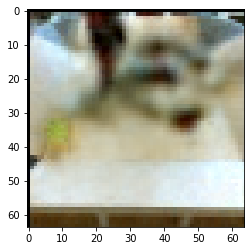

In [29]:
import matplotlib.pyplot as plt
plt.imshow(video[10,0].transpose(1,2,0))
plt.show()

In [18]:
video[8:16].max()

1.0

In [199]:
torch.log((1.0/((2 * 3.141592)**0.5 * torch.ones(1))))

tensor([-0.9189])

In [201]:
0.9189 * 10 * 64 * 64 * 3

112914.432